# Analysis of COB data using Cob() class and finding candidates
This notebook focuses on the implementation of the Cob class, which encompasses the analysis developed as part of the initial exploration of 15min sampled data as the output of Isabella Dagen's insulin-need project preprocessing. It uses the Cob class from cob_analysis.py to analyse the data and create peak features to investigate the existence of diurnal patterns in the data. This results in the application of methods to finalise a group of candidates to focus analysis on.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from loguru import logger

from src.cob_analysis import Cob, hierarchical_clustering, plot_cob_by_hour, plot_by_hour_individuals
from src.data_processing.read import get_all_offsets_df_from_profiles
from src.configurations import Configuration
from src.config import INTERIM_DATA_DIR
args = {'height': 15, 'distance': 5, 'suppress': True}

2025-05-26 22:46:24.765 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [2]:
# Previous preprocessing - 15 min sampled data based on earlier limited dataset
cob_old = Cob()
cob_old.read_interim_data(file_name='15min_iob_cob_bg_old_sample',
                      file_type='csv',
                      sampling_rate=15)

Number of records: 599360
Number of people: 116
Systems used: 	['OpenAPS']
Categories (1, object): ['OpenAPS']


In [3]:
# Compare briefly against the new dataset
cob_new = Cob()
cob_new.read_interim_data(file_name='15min_iob_cob_bg',
                      file_type='csv',
                      sampling_rate=15)

Number of records: 786757
Number of people: 133
Systems used: 	['OpenAPS']
Categories (1, object): ['OpenAPS']


In [4]:
# And compare to make sure missing values etc are the same
pid = 221634
cob_old.get_person_data(pid)
cob_new.get_person_data(pid)
cob_old.summarise_missing_for_individual()
cob_new.summarise_missing_for_individual()

MISSING DATA SUMMARY FOR 221634
Start of time series: 2018-03-16 20:30:00+00:00
End of time series: 2018-07-18 21:30:00+00:00
Samples: 2918
NaN values: 0
15-minute intervals in range: 11909
Missing samples: 8991
Total missing (NaNs and missing): 8991
Days in range: 124.05
Total % missing: 75.50
Days with COB data: 107
Days with missing data: 17.05
Number of gaps: 0
Mean length of gaps (in days): nan

MISSING DATA SUMMARY FOR 221634
Start of time series: 2018-03-16 20:30:00
End of time series: 2018-07-18 21:30:00
Samples: 2918
NaN values: 0
15-minute intervals in range: 11909
Missing samples: 8991
Total missing (NaNs and missing): 8991
Days in range: 124.05
Total % missing: 75.50
Days with COB data: 107
Days with missing data: 17.05
Number of gaps: 0
Mean length of gaps (in days): nan



{'n': 2918,
 'nans': np.int64(0),
 'min_date': Timestamp('2018-03-16 20:30:00'),
 'max_date': Timestamp('2018-07-18 21:30:00'),
 'num_intervals': 11909,
 'missing_samples': 8991,
 'total_missing': np.int64(8991),
 'days_in_range': 124.05208333333333,
 'missing_percent': np.float64(75.49752288185407),
 'days_with_data': 107,
 'days_with_missing_data': 17.05208333333333,
 'num_gaps': 0,
 'mean_gap_length_days': nan}

In [5]:
# Now lets look at processing the dataset to find the peaks, which will interpolate (to avoid increasing the number of peaks artificially) and same the processed data as a parquet file
logger.remove()
cob_new_df = cob_new.pre_process_batch(**args)

No IDs provided. Processing all 133 records.
2025-05-26 22:46:35.169 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:46:35.261 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
189 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:46:35.536 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:46:35.569 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
19 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:46:35.615 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:46:35.659 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
108 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:46:35.740 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-

No IDs provided. Processing all 116 records.
2025-05-26 22:48:01.949 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:48:01.968 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
189 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:48:01.990 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:48:02.010 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
19 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:48:02.042 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:48:02.084 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
108 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:48:02.134 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-

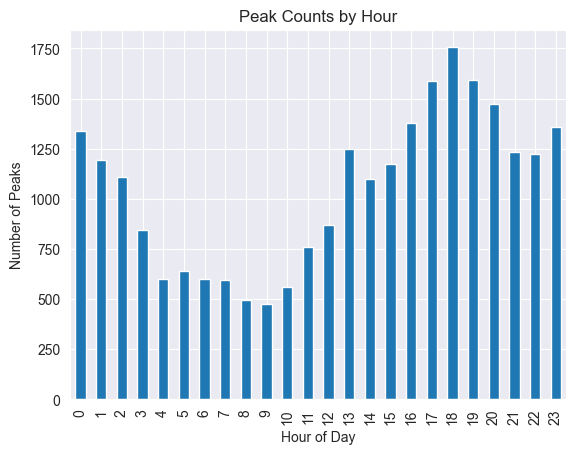

In [6]:
cob_old_df = cob_old.pre_process_batch(**args)
plot_cob_by_hour(cob_old_df)

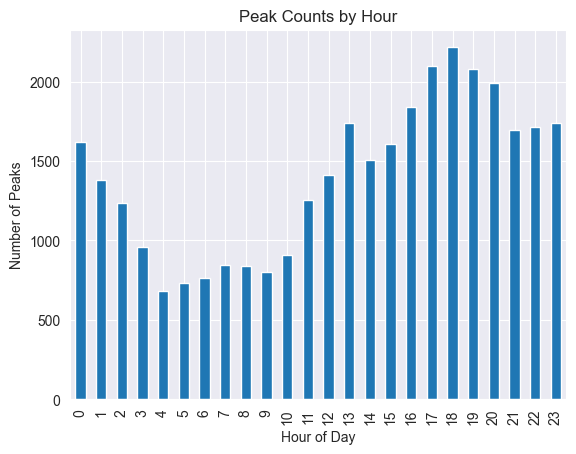

In [7]:
plot_cob_by_hour(cob_new_df)

This has now shown that despite the changes to localisation of datetime in the dataset, the peaks are still similar. We will focus on finding a set of well-behaved samples with rich COB data, and might help determine how far they are from the population profile.

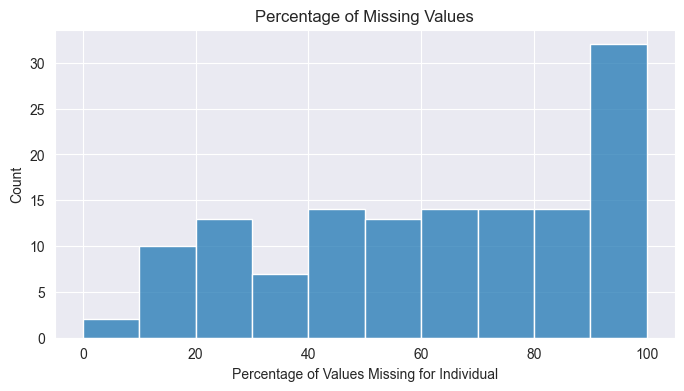

In [8]:
df_stats = cob_new.summarise_missing_for_dataset()

Now we've built a dataframe of variables we may use, we can start to see if there are clusters of people that meet the traits that we need in order to see if they have better-behaved data. One method we can use is hierarchical clustering, which will allow us to build a dendrogram to see if there are clusters of people that are similar data attributes, which favour a better behaved distribution of daily COB peaks.

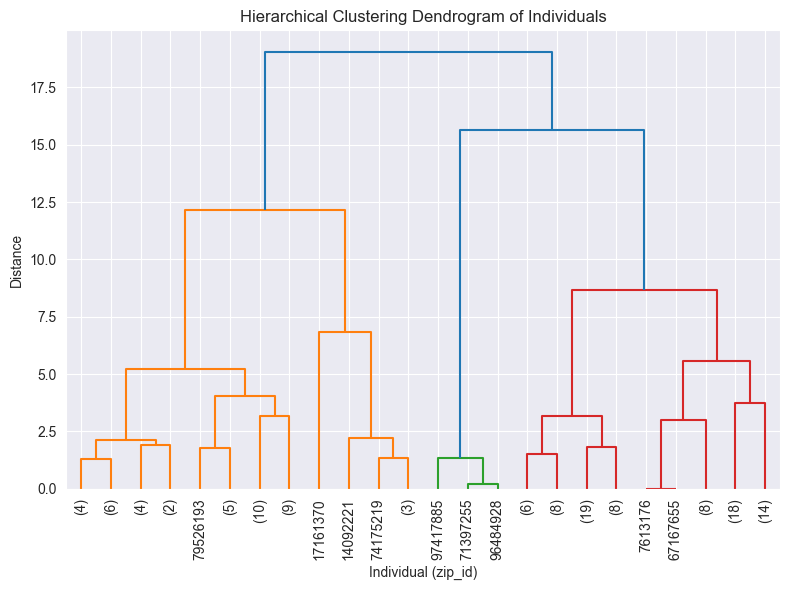


Cluster Sizes:
Cluster 3: 1 individuals
Cluster 4: 3 individuals
Cluster 2: 5 individuals
Cluster 6: 10 individuals
Cluster 7: 32 individuals
Cluster 1: 41 individuals
Cluster 5: 41 individuals


<Figure size 1000x800 with 0 Axes>

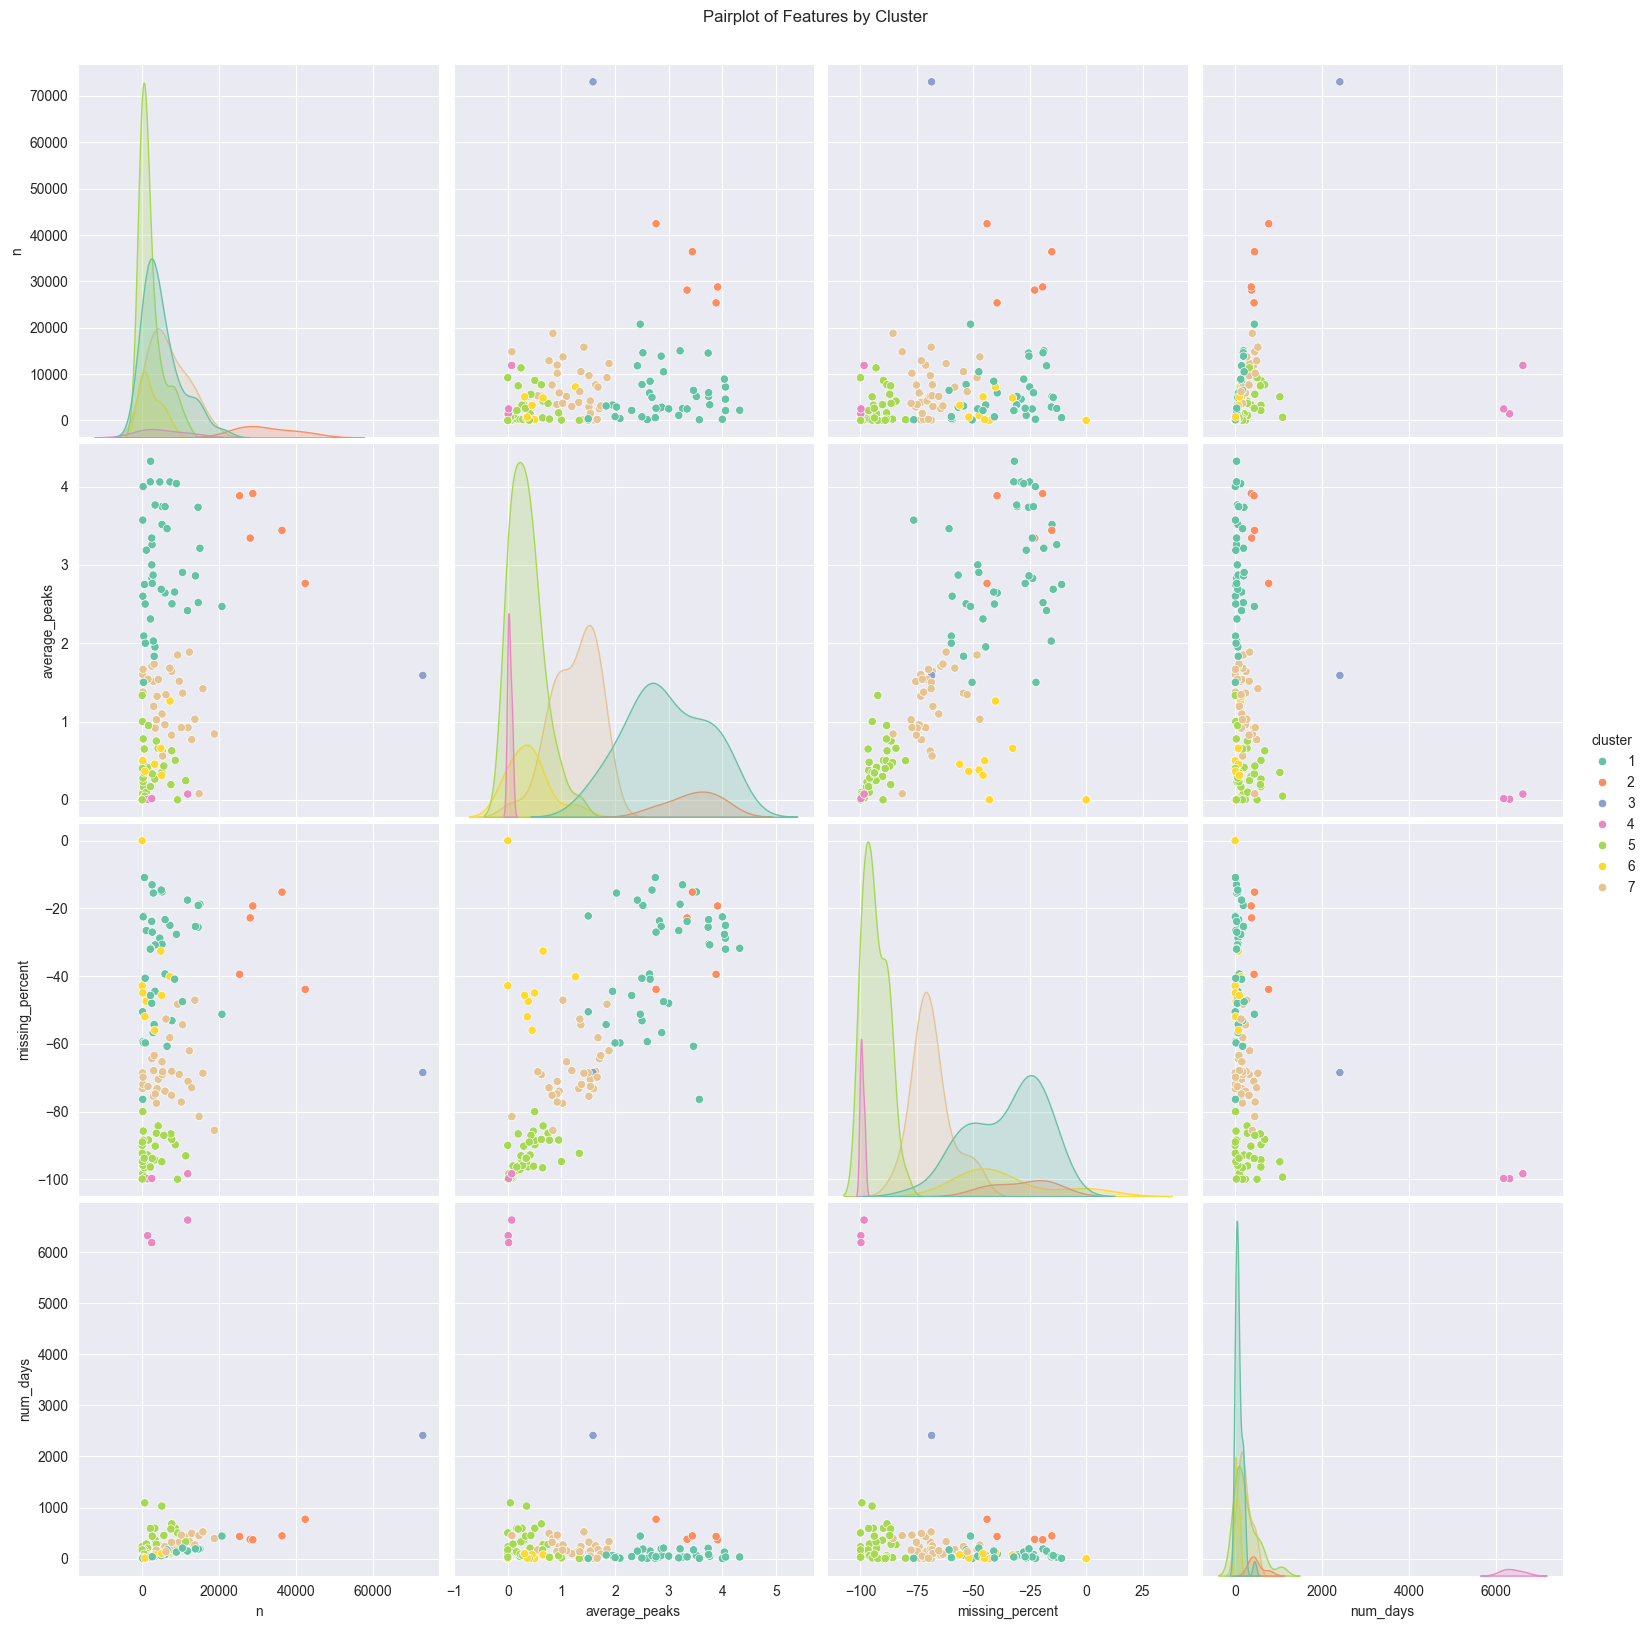

In [9]:
feature_cols = ['n','average_peaks','missing_percent','num_days']
df_summary = hierarchical_clustering(df_stats, feature_cols=feature_cols)

There is an outlier in the data that has a very high number of peaks and days with data. We'll remove this so we can get a better view of the data.


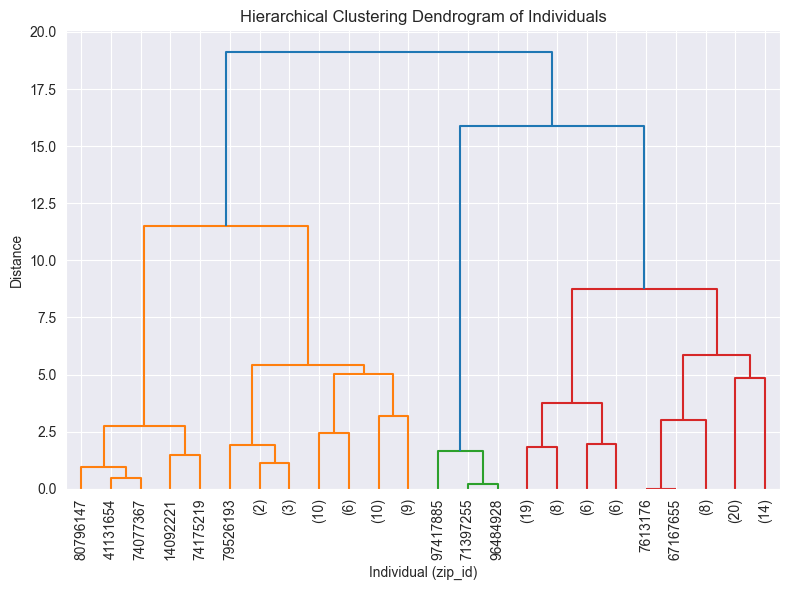


Cluster Sizes:
Cluster 4: 3 individuals
Cluster 1: 5 individuals
Cluster 2: 6 individuals
Cluster 6: 10 individuals
Cluster 7: 34 individuals
Cluster 3: 35 individuals
Cluster 5: 39 individuals


<Figure size 1000x800 with 0 Axes>

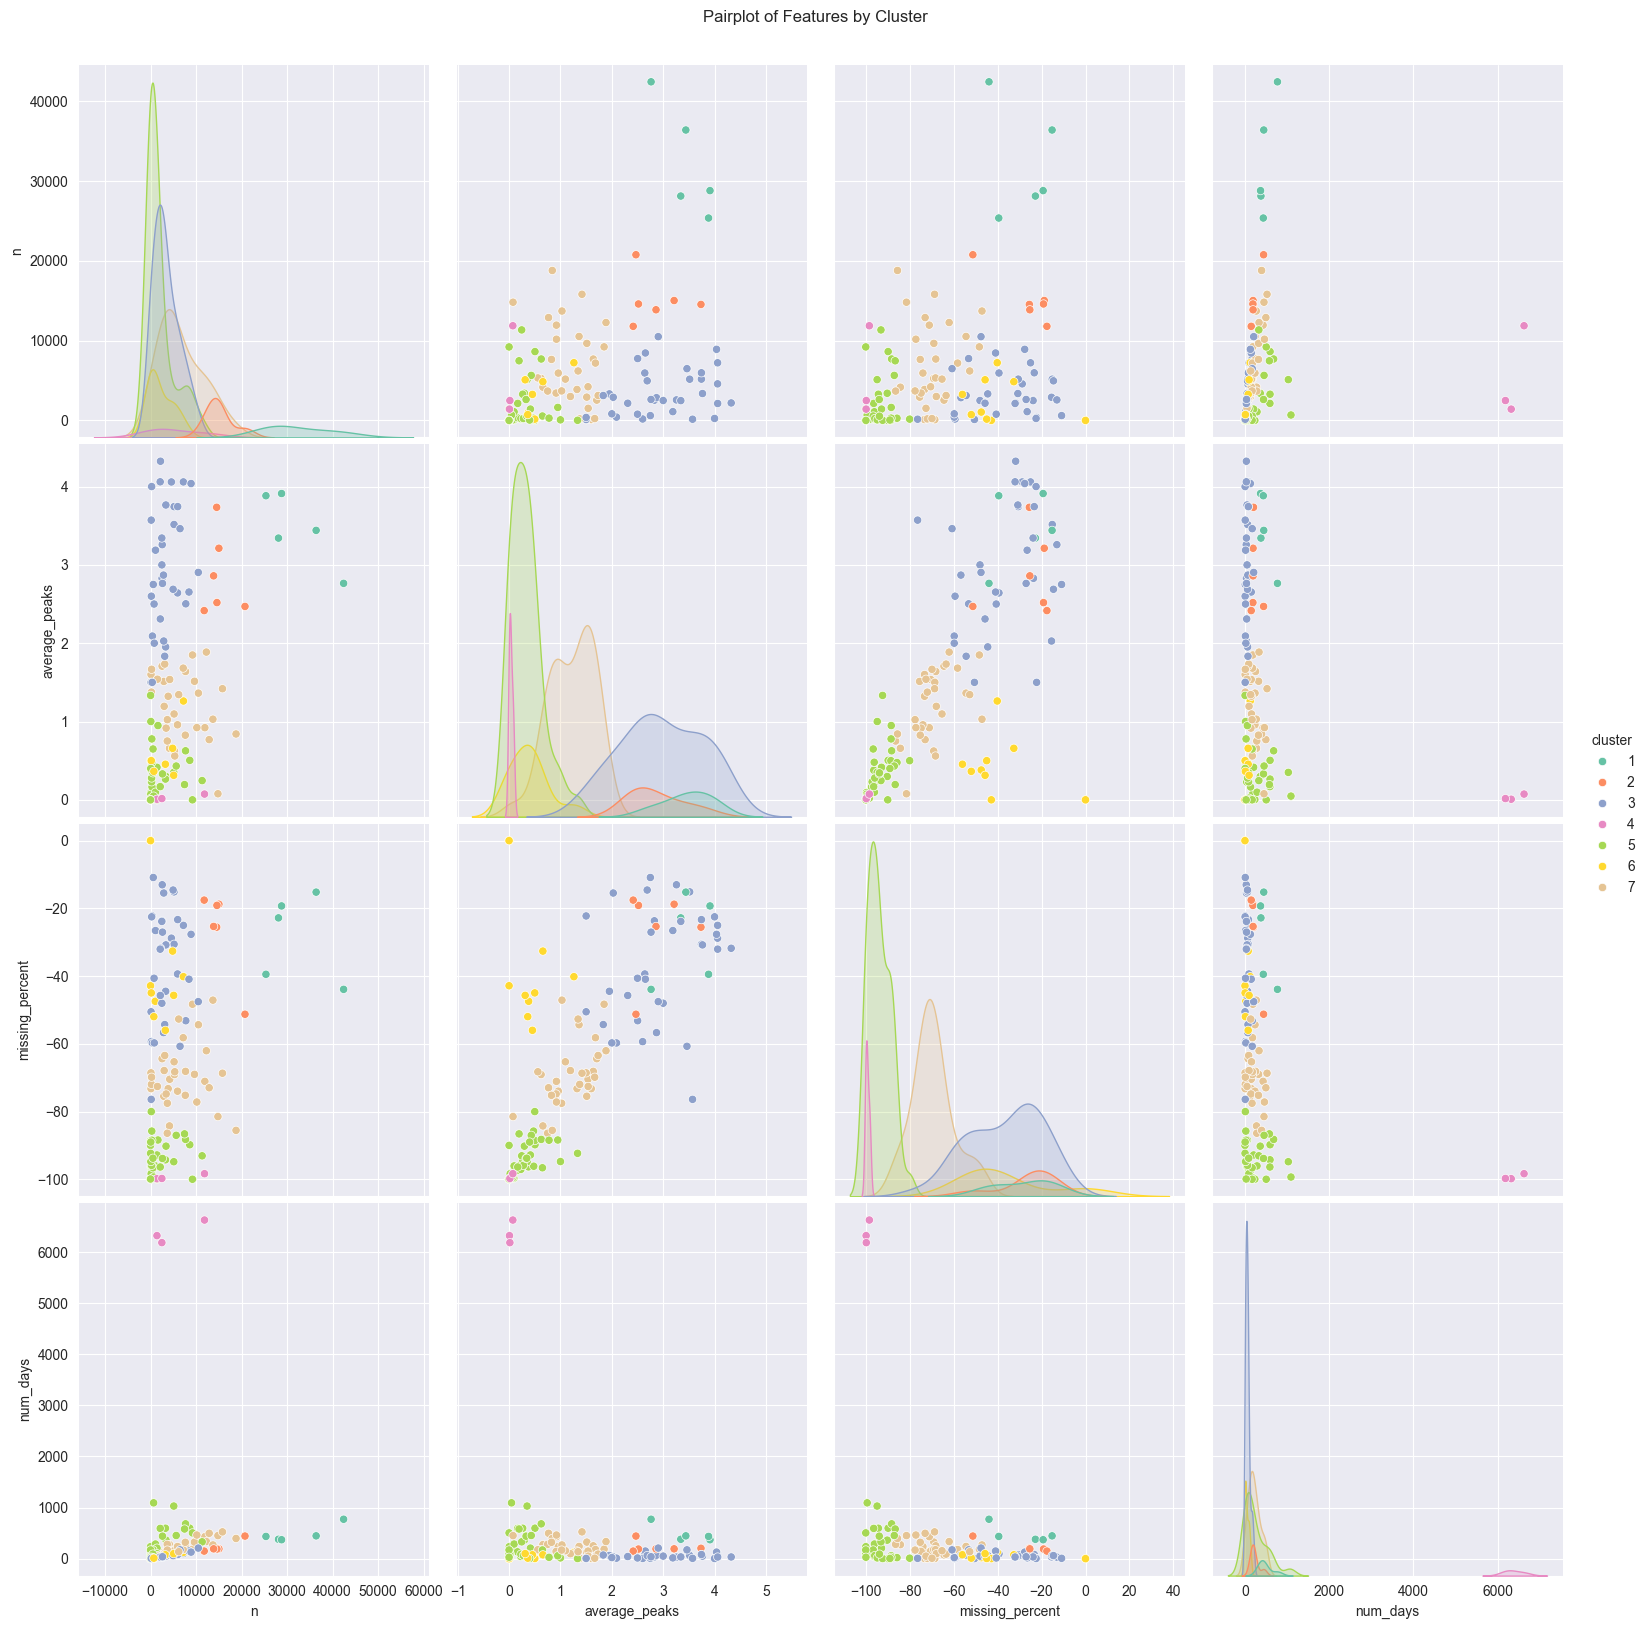

In [10]:
exclude = 17161370
df_summary_2 = hierarchical_clustering(df_summary.drop(index=[exclude]), feature_cols=feature_cols)

In [11]:
subset = list(df_summary.query('cluster == 1').index)
subset.append(exclude)

Now, we can apply the same day distribution of peaks analysis to the subset of people that we have identified as (more likely) having a good distribution of peaks.

2025-05-26 22:49:06.410 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:06.427 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
251 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:49:06.443 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:06.460 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
410 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:49:06.481 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:06.514 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
433 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:49:06.542 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:06.555 | INFO     | src.cob_analysi

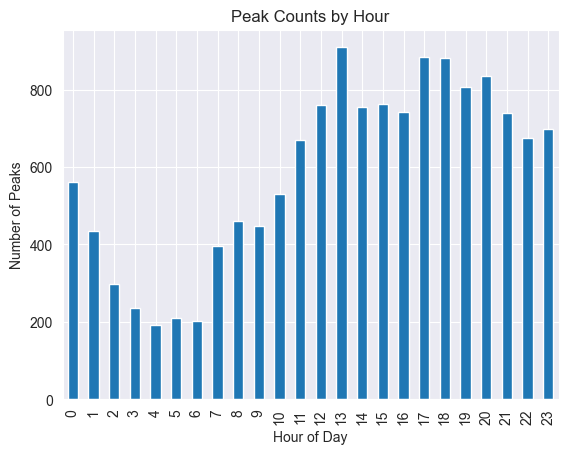

In [12]:
def plot_individual_cob(cob, pid):
    df = cob.pre_process_batch(ids=pid, **args)
    plot_cob_by_hour(df)

plot_individual_cob(cob_new, subset)

Lets have a look at the outlier individual, given that if there is an underlying distribution with their data that skews the data in a particular way, we may be able to identify it and choose to exclude it from the analysis.

2025-05-26 22:49:11.154 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:11.374 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
3832 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.


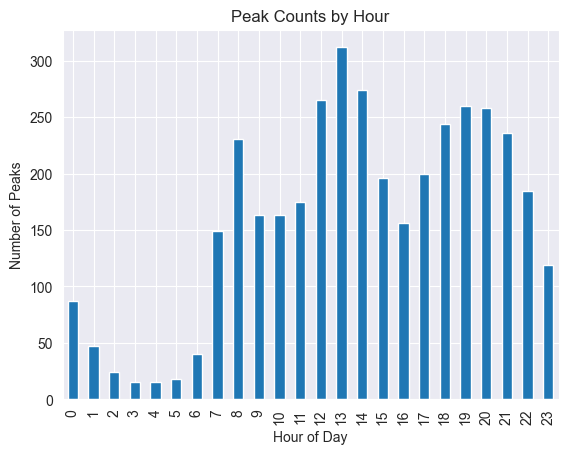

In [13]:
plot_individual_cob(cob_new, [exclude])

Now we see an anticipated distribution. There is a peak in the morning, at around a normal lunchtime in the UK, and then a peak in the evening. This is a very different distribution to the one we see in the full sample.

In [14]:
id_list = list(cob_new_df.index.get_level_values('id').unique())
print('Processed list...')
print(len(id_list))
print('Pre-processed ids...')
print(len(cob_new.dataset.index.get_level_values('id').unique()))


Processed list...
133
Pre-processed ids...
133


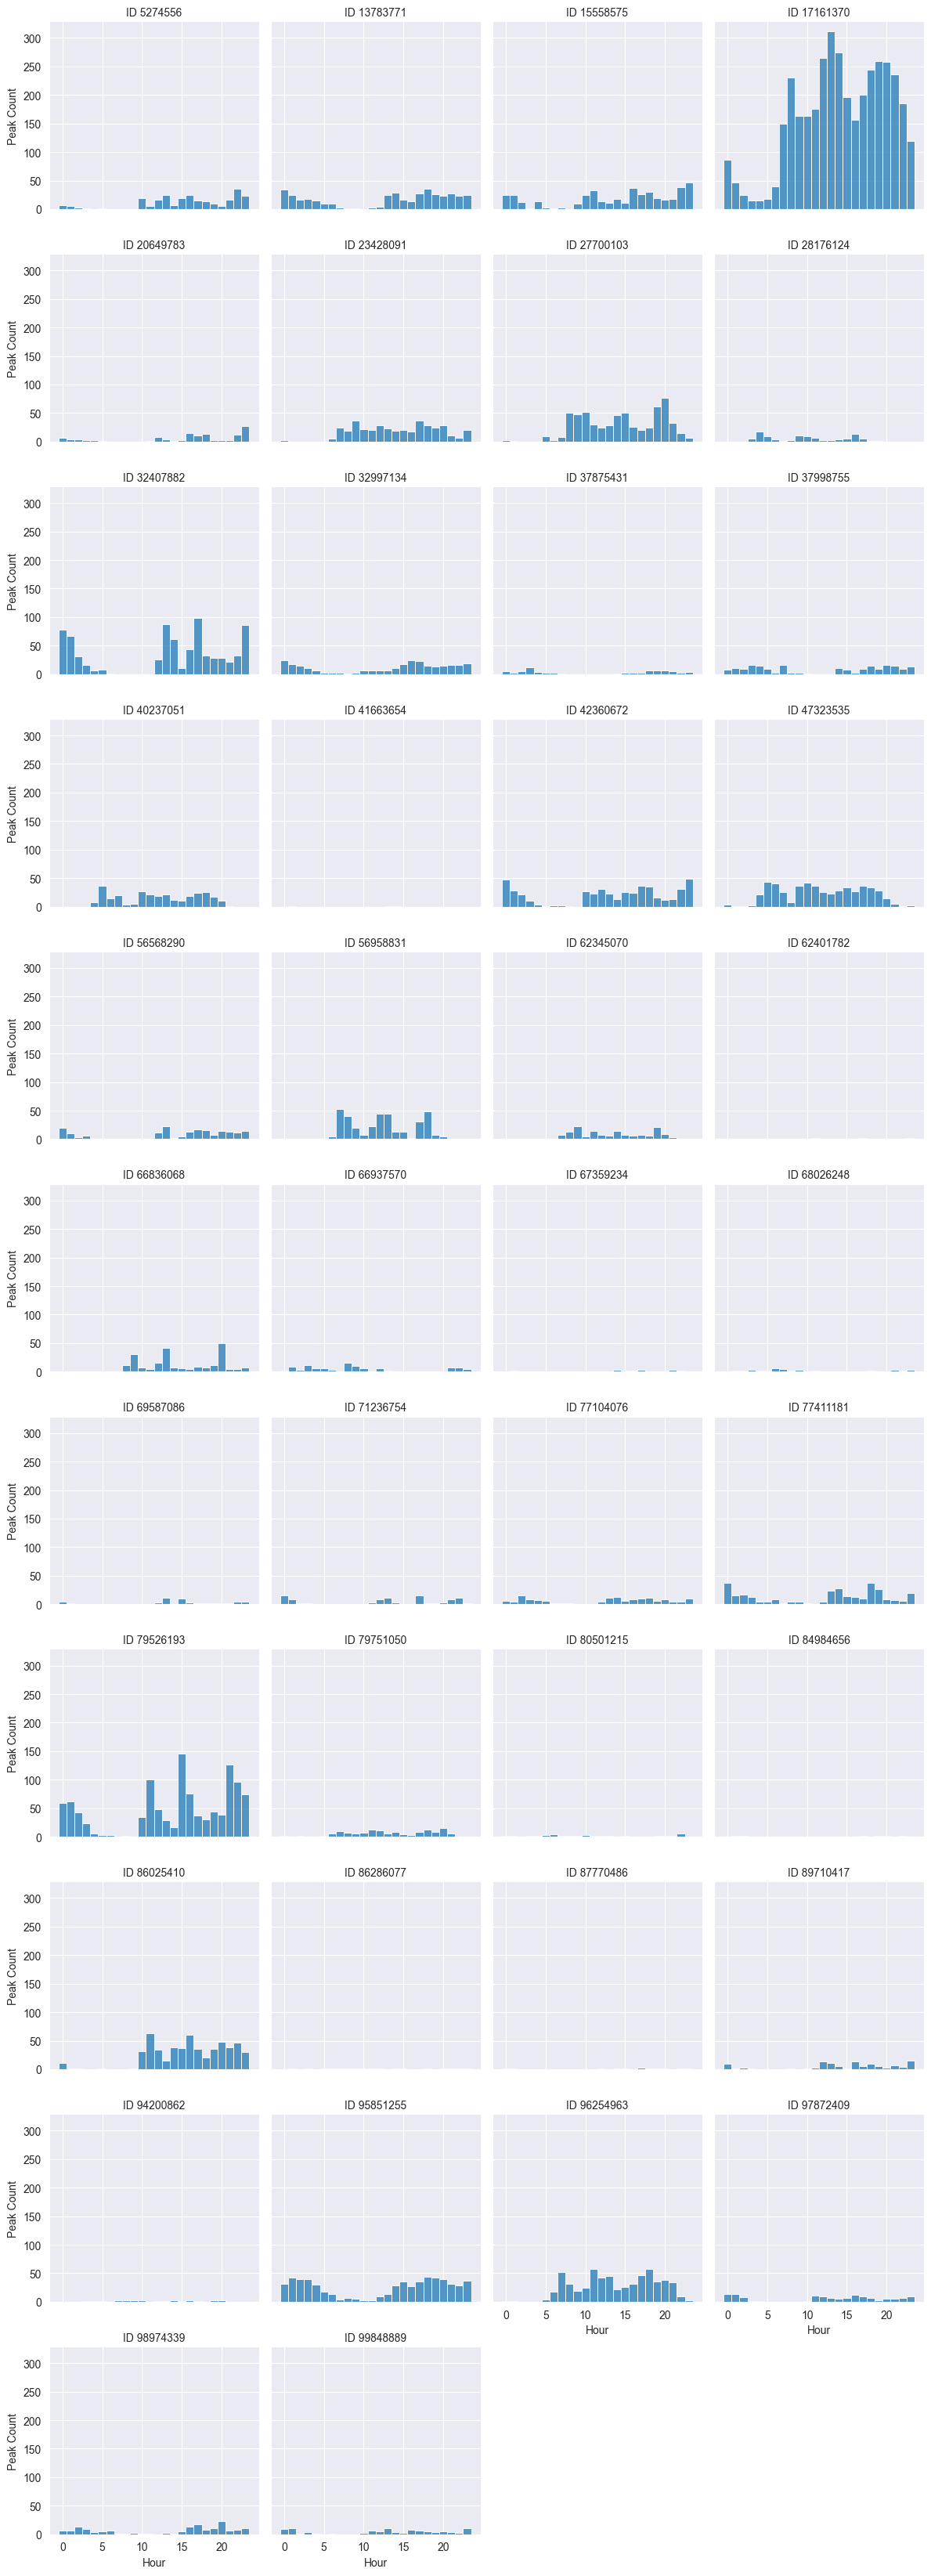

In [15]:
plot_by_hour_individuals(cob_new_df['peak'].loc[subset])

Here, there is evidence that the distributions are shifted, caused by inaccurate parsing of datetime. Particularly 14092221 and 41131654 show an odd distribution, especially the latter which infers that the person has a distribution shifted by some 10 hours (forward). Based on analysis done on the timezones, 41131654 has a timezone with a UTC offset of 12, denoted by the region in the profile file. The timestamps in the device status files do not have this timezone, therefore we can assume that these timestamps need the offset applying in order to localise them properly.Lets apply this and compare the distributions as this might be a treatment required across all individuals.

In [16]:
zip_id = 41131654

df_offset = cob_new.pre_process_batch(ids=[zip_id], **args)
df_offset.reset_index(inplace=True)
df_offset.head()

2025-05-26 22:49:23.153 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:23.197 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
1270 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.


,id,datetime,cob max,day,time,cob interpolate,peak
0,41131654,2019-08-31 13:15:00,0.0,2019-08-31,13:15:00,0.0,0
1,41131654,2019-08-31 13:30:00,0.0,2019-08-31,13:30:00,0.0,0
2,41131654,2019-08-31 13:45:00,0.0,2019-08-31,13:45:00,0.0,0
3,41131654,2019-08-31 14:00:00,0.0,2019-08-31,14:00:00,0.0,0
4,41131654,2019-08-31 14:15:00,0.0,2019-08-31,14:15:00,0.0,0


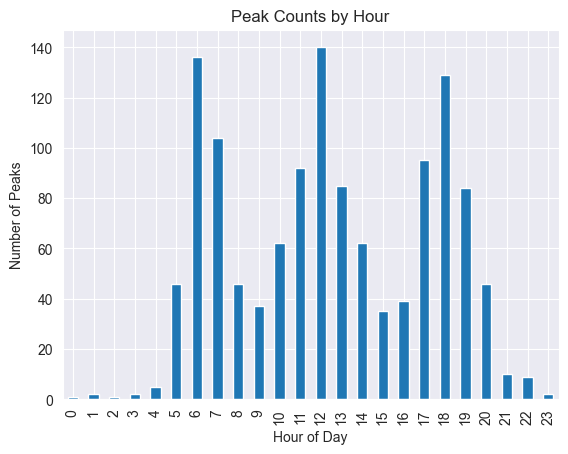

In [17]:

df_offset['datetime'] = df_offset['datetime'] + pd.Timedelta(hours=12)
df_offset['date'] = df_offset['datetime'].dt.date
df_offset['time'] = df_offset['datetime'].dt.time
df_offset.set_index(['id','datetime'], inplace=True)

plot_cob_by_hour(df_offset)

This appears to have corrected the distribution to one that is expected. So now, if we look at all the subset and adjust their offsets, do we get a different picture of distribution overall? Lets load the offsets and see.

In [18]:
df_regions = pd.read_csv(INTERIM_DATA_DIR / 'profile_region_utc_offset.csv', index_col=['zip_id','region_utc_offset'])

In [19]:
df_regions.loc[subset]

regions
zip_id   region_utc_offset                  
5274556  -4.0               America/Montreal
13783771 -5.0                America/Chicago
         -5.0                     US/Central
15558575 -4.0                     US/Eastern
20649783 -4.0                     US/Eastern
...                                      ...
17161370  0.0                      ETC/GMT+0
          2.0                  Europe/Madrid
          2.0                   Europe/Paris
          3.0                 Europe/Nicosia
          1.0                  Europe/Lisbon

[64 rows x 1 columns]

The problem we see here is that only 3 of the subset of 7 have a single datetime. This means we will either have to be very selective of which we use by limiting it to individuals with only one timezone, or we build in the complexity of offsetting the datetimes dependent on the profile, which will take significant further time. Thus, for now, we will run the prior analysis on the subset of people with only one timezone.

In [20]:
one_tz_ids = (df_regions.
 reset_index().
 drop(columns='regions').
 drop_duplicates().
 groupby('zip_id').
 agg({'region_utc_offset':'count'}).
 query('region_utc_offset==1').
 reset_index()['zip_id'].
 to_list()
 )

In [21]:
df_one_tz = (df_regions.loc[one_tz_ids]
             .reset_index()
             .groupby('zip_id')
             .agg({'region_utc_offset':'max'})
             .reset_index()
 )
df_one_tz.head()

,zip_id,region_utc_offset
0,221634,2.0
1,309157,10.0
2,1884126,-5.0
3,2033176,10.0
4,2050717,2.0


Now, having built a version of this into a function to read the profiles called get_all_offsets_df_from_profiles(), and then a function in the Cob class that called process_one_tz_individuals() which accepts in a dataframe of offsets to adjust the datetimes by. We've also created a file of profile offsets for those with only one profile timezone (iterating on the code below), which can be read using read_profile_offsets_csv().

In [22]:
config = Configuration()

# Get offsets from profiles - limited to individuals with one timezone
if config.profile_offsets_csv_file.exists():
    profile_offsets = (pd.read_csv(config.profile_offsets_csv_file, usecols=['id', 'offset'], dtype=int)
                       .set_index('id'))
else:
    profile_offsets = get_all_offsets_df_from_profiles(config)
    profile_offsets = (profile_offsets[
                           ~profile_offsets['id'].duplicated(keep=False) &
                           profile_offsets['offset'].notnull()].
                       set_index('id'))
    profile_offsets.to_csv(config.profile_offsets_csv_file)

print(f'Individuals with single timezones in profiles is {len(profile_offsets)}')
print(profile_offsets.info())


Individuals with single timezones in profiles is 120
<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 221634 to 99908129
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   offset  120 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB
None


In [23]:
cob_offset = Cob()
cob_offset.read_interim_data(file_name='15min_iob_cob_bg')
df_processed_offset = cob_offset.process_one_tz_individuals(profile_offsets, args)

Number of records: 786757
Number of people: 133
Systems used: 	['OpenAPS']
Categories (1, object): ['OpenAPS']
2025-05-26 22:49:28.563 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:28.584 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
189 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:49:28.598 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:28.623 | INFO     | src.cob_analysis:identify_peaks_for_individual:276 - 
19 peaks identified using parameters h=15 and d=5, and added to individual_dataset as a new column.
2025-05-26 22:49:28.655 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-05-26 22:49:28.661 | INFO     | src.cob_analysis:pre_process_batch:507 - Individual 1884126 not found in dataset, ignoring.
2025-05-26 22:49:28.661 | INFO     | src.cob_analysis:pre_process_batch:505 - Processing ID:
2025-

In [24]:
df_processed_offset

cob max         day      time  cob interpolate  \
id       datetime                                                              
221634   2018-03-16 22:30:00    0.000  2018-03-16  22:30:00            0.000   
         2018-03-16 22:45:00    0.000  2018-03-16  22:45:00            0.466   
         2018-03-16 23:00:00    0.932  2018-03-16  23:00:00            0.932   
         2018-03-16 23:15:00    0.000  2018-03-16  23:15:00            0.699   
         2018-03-16 23:30:00    0.000  2018-03-16  23:30:00            0.466   
...                               ...         ...       ...              ...   
99908129 2018-01-31 23:45:00    0.000  2018-01-31  23:45:00            0.000   
         2018-02-01 00:00:00    0.000  2018-02-01  00:00:00            0.000   
         2018-02-01 00:15:00    0.000  2018-02-01  00:15:00            0.000   
         2018-02-01 00:30:00    0.000  2018-02-01  00:30:00            0.000   
         2018-02-01 00:45:00    0.000  2018-02-01  00:45:00            0.000   

                              peak  offset  
id       datetime                           
221634   2018-03-16 22:30:00     0       2  
         2018-03-16 22:45:00     0       2  
         2018-03-16 23:00:00     0       2  
         2018-03-16 23:15:00     0       2  
         2018-03-16 23:30:00     0       2  
...                            ...     ...  
99908129 2018-01-31 23:45:00     0      -4  
         2018-02-01 00:00:00     0      -4  
         2018-02-01 00:15:00     0      -4  
         2018-02-01 00:30:00     0      -4  
         2018-02-01 00:45:00     0      -4  

[2637045 rows x 6 columns]

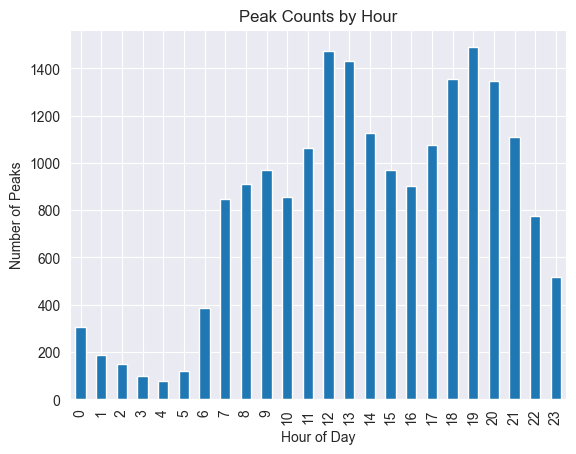

In [25]:
plot_cob_by_hour(df_processed_offset)

Now lets run the clustering process to see what our new group looks like, based on the now-filtered list of people.

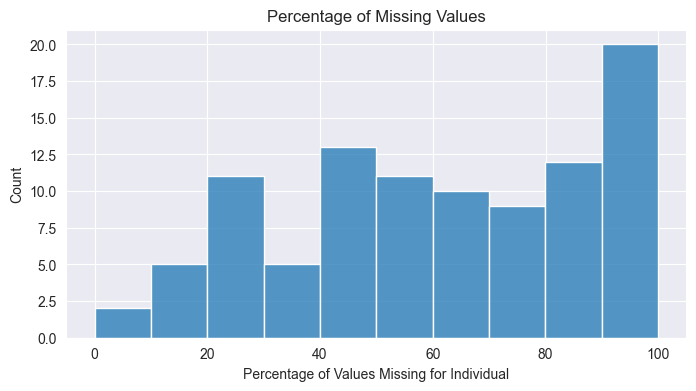

In [26]:
summary_offset = cob_offset.summarise_missing_for_dataset(limit_to_processed=True)

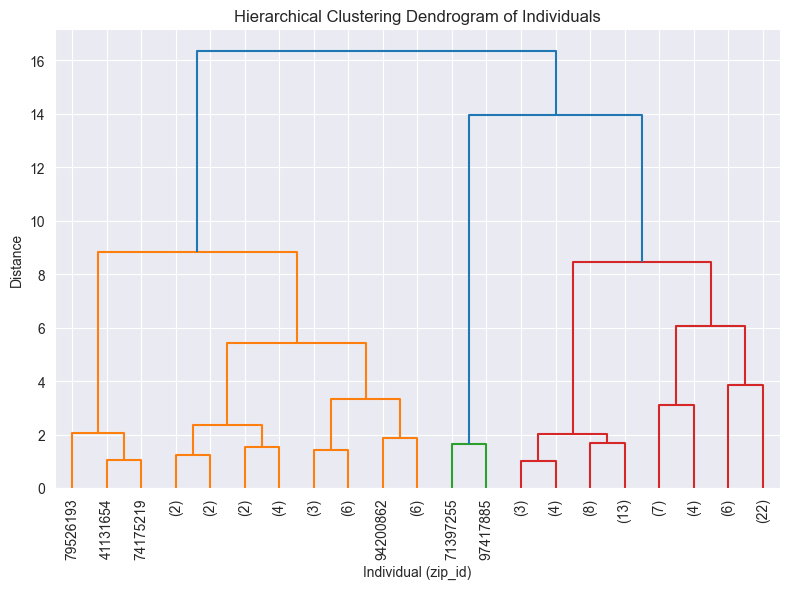


Cluster Sizes:
Cluster 4: 2 individuals
Cluster 1: 3 individuals
Cluster 2: 10 individuals
Cluster 6: 11 individuals
Cluster 3: 16 individuals
Cluster 5: 28 individuals
Cluster 7: 28 individuals


<Figure size 1000x800 with 0 Axes>

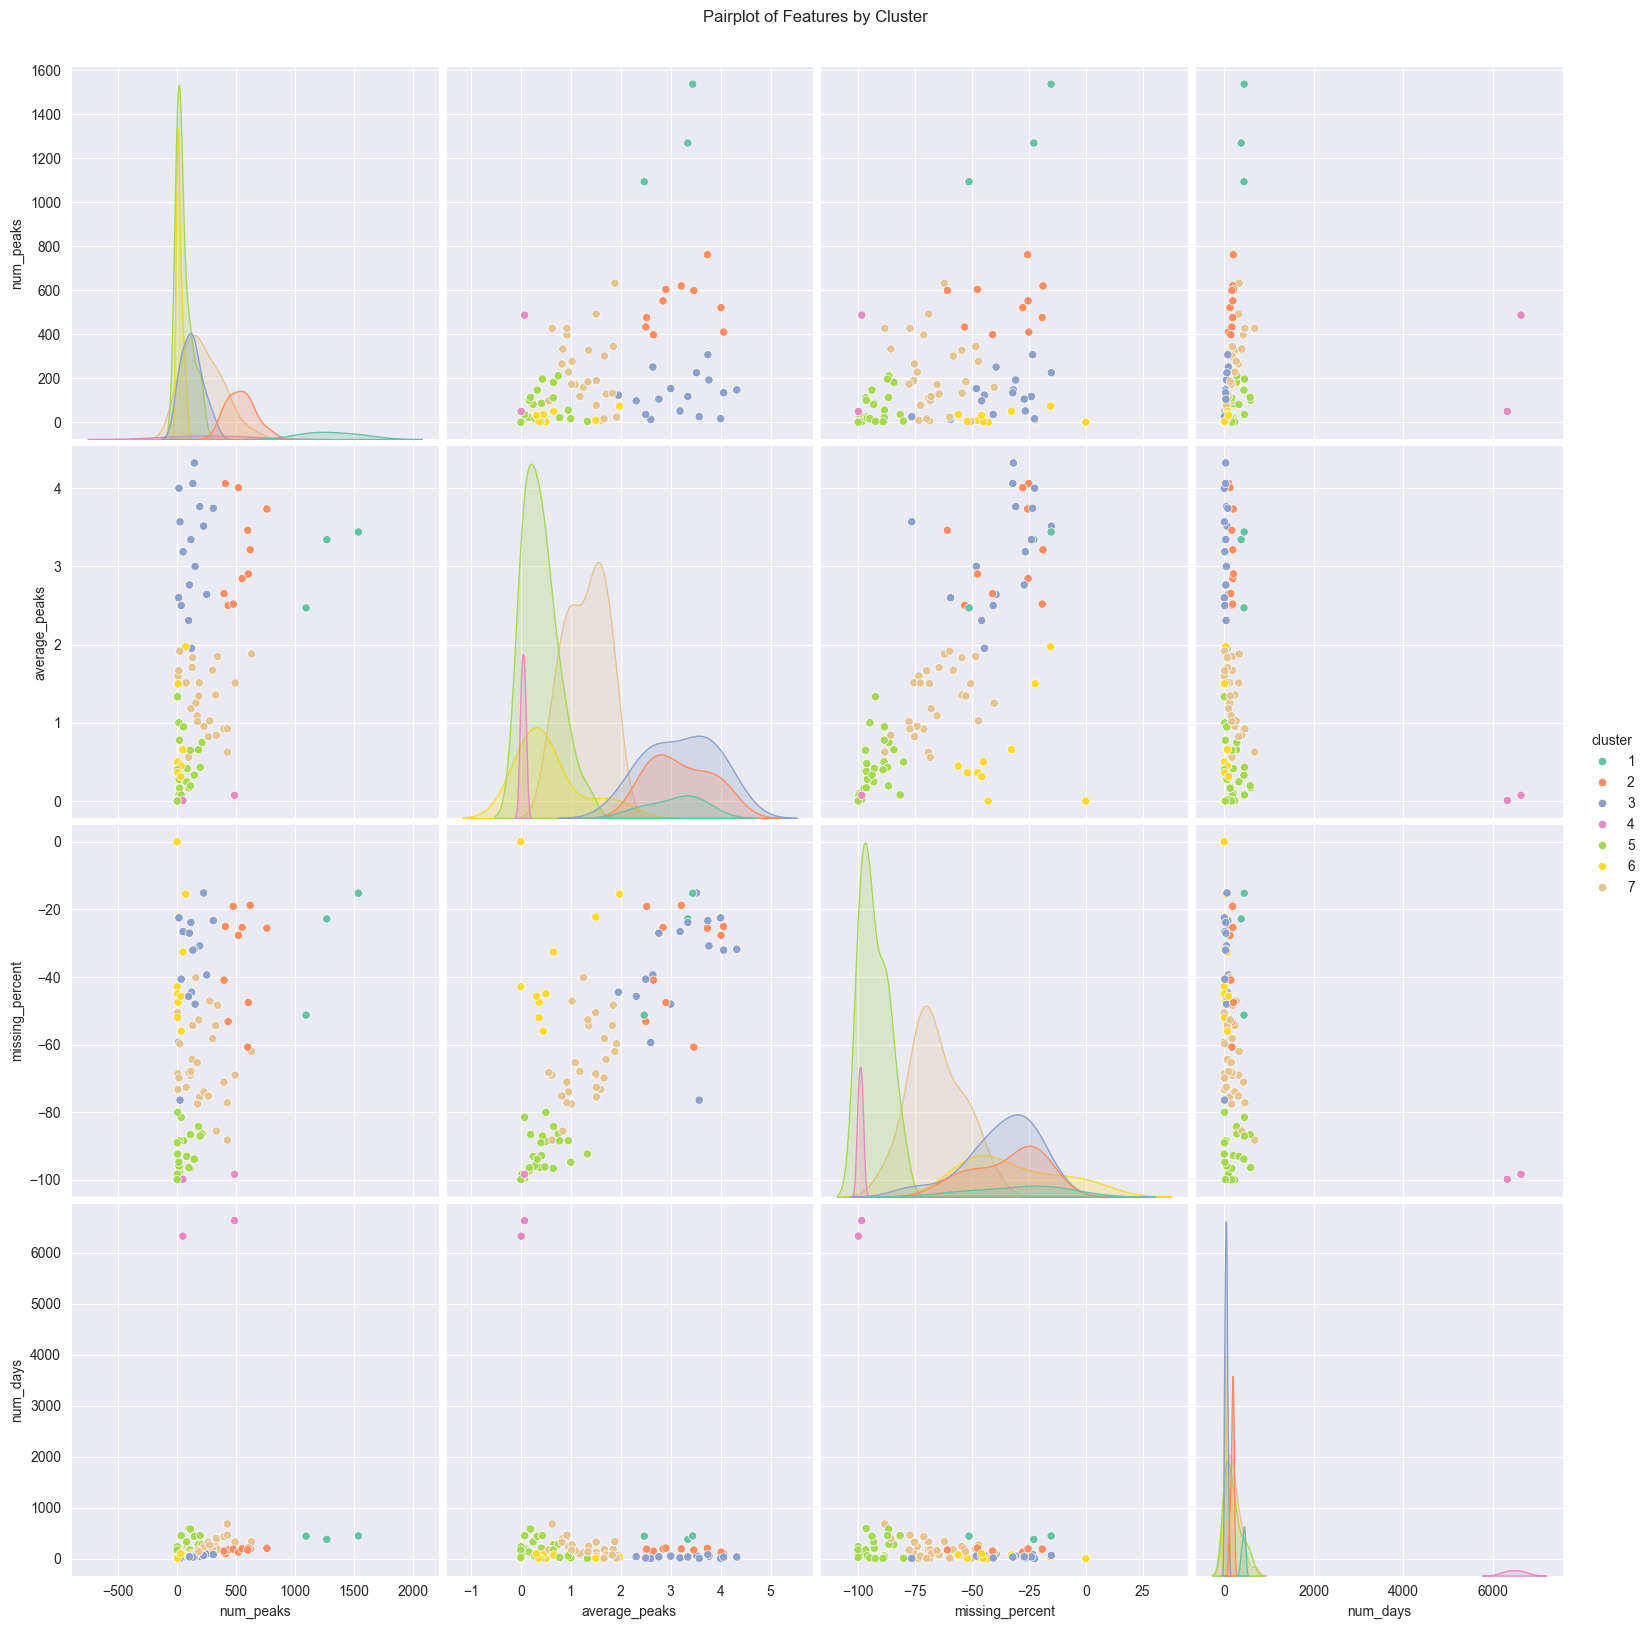

In [27]:
feature_cols = ['num_peaks','average_peaks','missing_percent','num_days']
summary_offset = hierarchical_clustering(summary_offset, feature_cols=feature_cols)

Clusters 1 and 7 look like good candidates based on clustering above. Lets start with these and see how our distributions look.

In [28]:
new_subjects = summary_offset.loc[summary_offset['cluster'].isin([5, 7])].index.drop_duplicates().astype(int).tolist()
print('Chosen subjects for study:')
print(new_subjects)

Chosen subjects for study:
[221634, 309157, 2033176, 2050717, 2611986, 3572116, 4762925, 13029224, 13484299, 15634563, 19626656, 20216809, 21946407, 22961398, 24587372, 26856617, 28608066, 28768536, 35187603, 37764532, 37948668, 38110191, 39182506, 39986716, 41663654, 47750728, 49182092, 52804089, 54280576, 57176789, 63047517, 63725802, 64024750, 64406000, 67208817, 67359234, 68267781, 69965708, 70454270, 70811987, 71618088, 72492570, 73398408, 73521474, 76817975, 79751050, 84241955, 84589080, 85653830, 88004055, 90398368, 93606058, 93839818, 93937579, 96805916, 99908129]


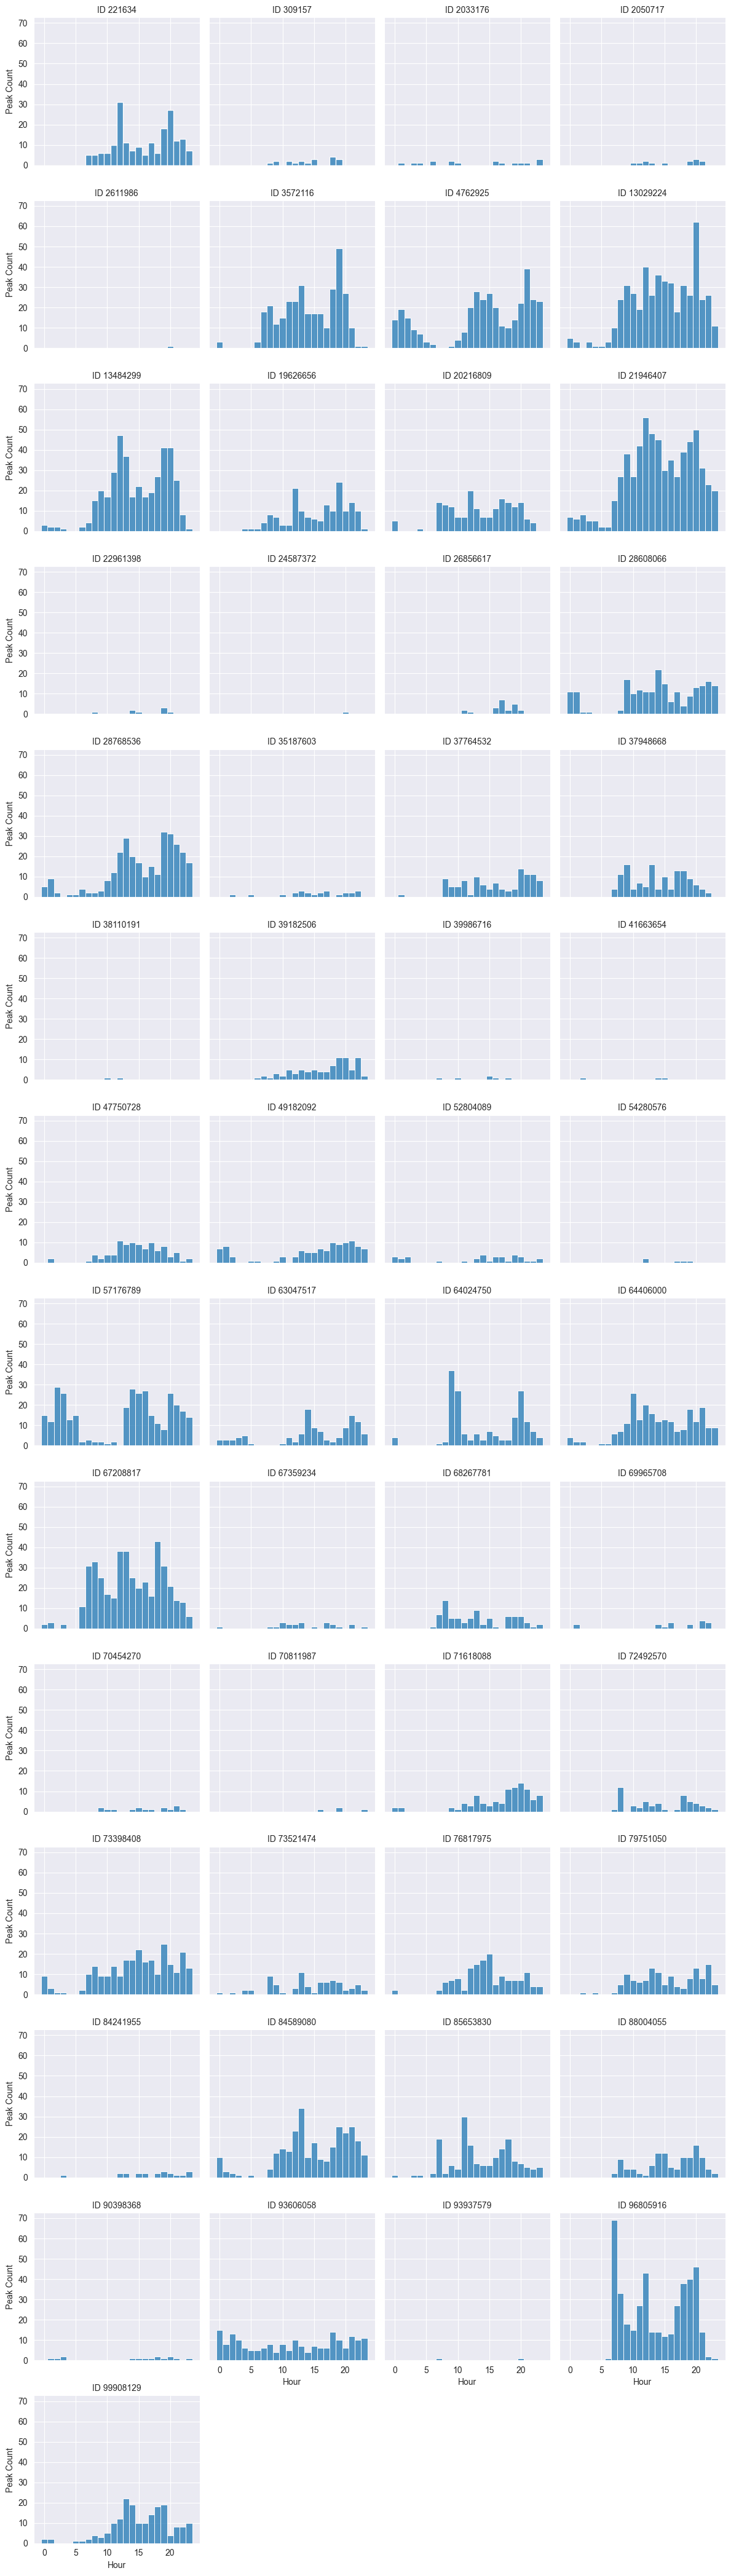

In [29]:
plot_by_hour_individuals(cob_offset.processed_dataset.
                         loc[new_subjects]['peak'])

Now happy with this group of people and clustering, we'll start the time series analysis on these datasets.